In [14]:
import os
import json
import pyqg_subgrid_experiments as pse
import argparse
import time
import torch
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
torch.cuda.is_available()

True

In [3]:
parser = argparse.ArgumentParser()
parser.add_argument('--train_set', type=str, default="/scratch/zanna/data/pyqg/data/train/*.nc")
parser.add_argument('--test_set', type=str, default="/scratch/zanna/data/pyqg/data/test/*.nc")
parser.add_argument('--transfer_set', type=str, default="/scratch/zanna/data/pyqg/data/transfer/*.nc")
parser.add_argument('--save_dir', type=str, default="ROSS_cnn")
parser.add_argument('--inputs', type=str, default="u,v,q")
parser.add_argument('--targets', type=str, default="q_forcing_advection")
parser.add_argument('--zero_mean', type=int, default=1)
parser.add_argument('--num_epochs', type=int, default=50)
parser.add_argument('--layerwise_inputs', type=int, default=0)
parser.add_argument('--layerwise_targets', type=int, default=0)

_StoreAction(option_strings=['--layerwise_targets'], dest='layerwise_targets', nargs=None, const=None, default=0, type=<class 'int'>, choices=None, help=None, metavar=None)

In [4]:
args = parser.parse_args("")

In [5]:
save_dir = args.save_dir
test_dir = os.path.join(save_dir, "test")
xfer_dir = os.path.join(save_dir, "transfer")
for d in [save_dir, test_dir, xfer_dir]:
    os.system(f"mkdir -p {d}") 

with open(f"{save_dir}/model_config.json", 'w') as f:
    f.write(json.dumps(args.__dict__))

In [6]:
train = pse.Dataset(args.train_set)

In [9]:
param = pse.CNNParameterization.train_on(train, save_dir,
            inputs=args.inputs.split(","),
            targets=args.targets.split(","),
            layerwise_inputs=args.layerwise_inputs,
            layerwise_targets=args.layerwise_targets,
            zero_mean=args.zero_mean,
            num_epochs=50)

In [10]:
test = pse.Dataset(args.test_set)
xfer = pse.Dataset(args.transfer_set)

In [36]:
test_result = param.test_offline(test, os.path.join(test_dir, "offline_metrics.nc"), force=True)

Current mode: False
Mode after eval(): False


/ext3/miniconda3/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


In [26]:
transfer_result = param.test_offline(xfer, os.path.join(xfer_dir, "offline_metrics.nc"))

Current mode: False
Mode after eval(): False


/ext3/miniconda3/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/ext3/miniconda3/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


/ext3/miniconda3/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


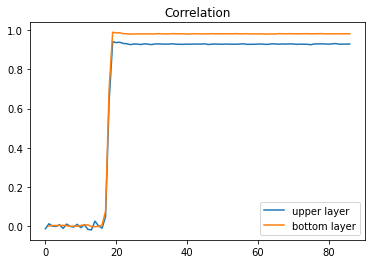

In [37]:
ds = test_result
plt.plot(ds.q_forcing_advection_temporal_correlation)
#plt.ylim([0,2])
plt.legend(['upper layer', 'bottom layer'])
plt.title('Correlation')
plt.show()

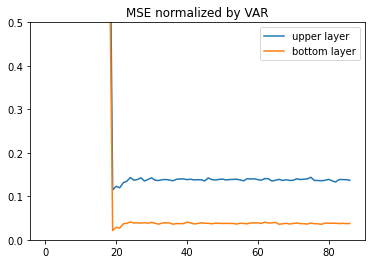

In [39]:
ds = test_result
plt.plot(1-ds.q_forcing_advection_temporal_skill)
plt.ylim([0,0.5])
plt.legend(['upper layer', 'bottom layer'])
plt.title('MSE normalized by VAR')
#plt.hlines(y=[0.15,0.05],xmin=20,xmax=90,linestyle='--')
#plt.text(5,0.15,'y=0.15')
#plt.text(5,0.05,'y=0.05')
plt.show()